In [1]:
#Financial Computing HW5
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
#input values setting
st = 50
save = 50
K = 50
r = 0.1
q = 0.05
sigma = 0.8
n = 100
M = 100


In [2]:
#CRR for Arithmetic_call
def Arithmetic_call(st, save, K, r, q, sigma, T, t, n, M, method, type):
    dt = T/n
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp((r-q)*dt)-d)/(u-d)
    s = np.zeros((n+1, n+1))
    A = np.zeros((n+1, n+1, M+1))
    call = np.zeros((n+1, n+1, M+1))
    Amax = np.zeros((n+1, n+1))
    Amin = np.zeros((n+1, n+1))
    s[0, 0] = st

    #Stock prices tree
    for i in range(0, n+1):
        for j in range(n-1, n+1):
            if i <= j:
                s[i, j] = st*(u**(j-i))*(d**i)
    if n%2 == 0:
        s[int(n/2), n] = st
    else:
        s[int((n-1)/2), n-1] = st

    for j in range(n-2, 0, -1):
        for i in range(0, j+1):
            s[i, j] = s[i+1, j+2]

    #Compute Amax and Amin, represent average prices by equally spaced
    for i in range(0, n+1):
        for j in range(0, n+1):
            for k in range(0, M+1):
                if i <= j:
                    Amax[i, j] = (save*(n*(t/T)+1)+st*u*(1-u**(j-i))/(1-u)+st*u**(j-i)*d*(1-d**i)/(1-d))/(j+(n*(t/T)+1))
                    Amin[i, j] = (save*(n*(t/T)+1)+st*d*(1-d**i)/(1-d)+st*u*(d**i)*(1-u**(j-i))/(1-u))/(j+(n*(t/T)+1))
                if method == 'linear':
                    A[i, j, k] = ((M-k)/M)*Amax[i, j] + (k/M)*Amin[i, j]
                elif method == 'log':
                    A[i, j, k] = np.exp(((M-k)/M)*np.log(Amax[i, j]) + (k/M)*np.log(Amin[i, j]))

    #The call value of the last column
    for i in range(0, n+1):
        for k in range(0, M+1):
            call[i, n, k] = max(0, A[i, n, k]-K)

    #Compute the European average call price
    for j in range(n-1, -1, -1):
        for i in range(0, j+1):
            for k in range(0, M+1):
                Au = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j+1-i)*d**i)/(j+(n*(t/T)+1)+1)
                Ad = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j-i)*d**(i+1))/(j+(n*(t/T)+1)+1)
                for ku in range(0, M+1):
                    if Au >= A[i, j+1, 0]:
                        Cu = call[i, j+1, 0]
                    elif Au <= A[i, j+1, M]:
                        Cu = call[i, j+1, M]
                    elif Au == A[i, j+1, ku]:
                        Cu = call[i, j+1, ku]
                    elif Au>A[i, j+1, ku] and Au<A[i, j+1, ku-1]:
                        wu = (A[i, j+1, ku-1]-Au)/(A[i, j+1, ku-1]-A[i, j+1, ku])
                        Cu = wu*call[i, j+1, ku]+(1-wu)*call[i, j+1, ku-1]
                for kd in range(0, M+1):
                    if Ad >= A[i+1, j+1, 0]:
                        Cd = call[i+1, j+1, 0]
                    elif Ad <= A[i+1, j+1, M]:
                        Cd = call[i+1, j+1, M]
                    elif Ad == A[i+1, j+1, kd]:
                        Cd = call[i+1, j+1, kd]
                    elif Ad>A[i+1, j+1, kd] and Ad<A[i+1, j+1, kd-1]:
                        wd = (A[i+1, j+1, kd-1]-Ad)/(A[i+1, j+1, kd-1]-A[i+1, j+1, kd])
                        Cd = wd*call[i+1, j+1, kd]+(1-wd)*call[i+1, j+1, kd-1]
                call[i, j, k] = np.exp(-r*dt)*(p*Cu+(1-p)*Cd)
                if type == 'European':
                    pass
                elif type == 'American':
                    call[i, j, k] = max(call[i, j, k], A[i, j, k]-K)

    return call[0, 0, 0] 
print('t = 0: the European average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'European'))
print('t = 0.25: the European average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'European'))
print('t = 0: the American average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'American'))
print('t = 0.25: the American average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'American'))

t = 0: the European average call price is 4.735385345731979
t = 0.25: the European average call price is 2.379472238402664
t = 0: the American average call price is 5.4145899579662276
t = 0.25: the American average call price is 2.507865849655306


In [42]:
#Monte Carlo Simulation
st = 50
save = 50
K = 50
r = 0.1
q = 0.05
sigma = 0.8
n = 100
num_simulations = 10000
num_repetitions = 20

def Arithmetic_european_call(save, K, r, q, sigma, T, t, n, num_simulations, num_repetitions):
    dt = T/n
    n_before_t = n*(t/T)+1
    call_average = []
    for i in range(num_repetitions):
        call = []
        for j in range(num_simulations):
            count = 0
            st_ = list(np.repeat(save, n_before_t))
            while count<n:
                z = norm.rvs(0, 1)
                st_.append(np.exp(z*sigma*np.sqrt(dt)+np.log(st_[-1])+(r-q-0.5*sigma*sigma)*dt))
                count += 1
            call.append(max(np.mean(st_)-K, 0))
        call_average.append(np.exp(-r*T)*np.mean(call))
    return np.mean(call_average), np.mean(call_average)+2*np.std(call_average), np.mean(call_average)-2*np.std(call_average)

print('t=0:')
print('the price of Arithmetic_European_call and the 95% confidence interval are', 
Arithmetic_european_call(save, K, r, q, sigma, 0.25, 0, n, num_simulations, num_repetitions))

print('t=0.25:')
print('the price of Arithmetic_European_call and the 95% confidence interval are', 
Arithmetic_european_call(save, K, r, q, sigma, 0.25, 0.25, n, num_simulations, num_repetitions))

t=0:
the price of Arithmetic_European_call and the 95% confidence interval are (4.630124358143668, 4.801664072572193, 4.458584643715143)
t=0.25:
the price of Arithmetic_European_call and the 95% confidence interval are (2.3276479173306086, 2.418995744687874, 2.2363000899733434)


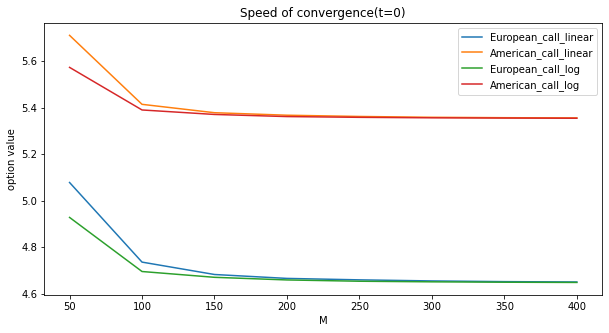

In [21]:
#Bonus 1
#t=0
M_ = [i for i in range(50, 450, 50)]
European_call_linear = []
American_call_linear = []
European_call_log = []
American_call_log = []
for M in M_:
    European_call_linear.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'European'))
    American_call_linear.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'American'))
    European_call_log.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'log', 'European'))
    American_call_log.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'log', 'American'))
    
equally_spaced_method = {
    'M':[50, 100, 150, 200, 250, 300, 350, 400],
    'European_call_linear':European_call_linear,
    'American_call_linear':American_call_linear,
    'European_call_log':European_call_log,
    'American_call_log':American_call_log
}
df = pd.DataFrame(equally_spaced_method)
df.to_csv('equally_spaced_method.csv')
df.set_index('M').plot(title='Speed of convergence(t=0)', xlabel='M',  ylabel='option value',  legend=True,  figsize=(10, 5)) 
plt.savefig('Speed_of_convergence_t=0.png')

<ipython-input-2-3dc1a4451117>:38: RuntimeWarning: divide by zero encountered in log
  A[i, j, k] = np.exp(((M-k)/M)*np.log(Amax[i, j]) + (k/M)*np.log(Amin[i, j]))
<ipython-input-2-3dc1a4451117>:38: RuntimeWarning: invalid value encountered in double_scalars
  A[i, j, k] = np.exp(((M-k)/M)*np.log(Amax[i, j]) + (k/M)*np.log(Amin[i, j]))


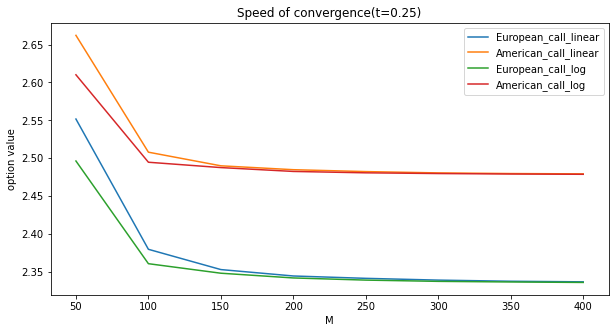

In [3]:
#Bonus 1
#t=0.25
M_ = [i for i in range(50, 450, 50)]
European_call_linear = []
American_call_linear = []
European_call_log = []
American_call_log = []
for M in M_:
    European_call_linear.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'European'))
    American_call_linear.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'American'))
    European_call_log.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'log', 'European'))
    American_call_log.append(Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'log', 'American'))
    
equally_spaced_method = {
    'M':[50, 100, 150, 200, 250, 300, 350, 400],
    'European_call_linear':European_call_linear,
    'American_call_linear':American_call_linear,
    'European_call_log':European_call_log,
    'American_call_log':American_call_log
}
df = pd.DataFrame(equally_spaced_method)
df.to_csv('equally_spaced_method.csv')
df.set_index('M').plot(title='Speed of convergence(t=0.25)', xlabel='M',  ylabel='option value',  legend=True,  figsize=(10, 5)) 
plt.savefig('Speed_of_convergence_t=0.25.png')

In [5]:
import os
os.getcwd()

'C:\\Users\\steven\\iCloudDrive\\Desktop\\碩二下\\金融計算\\HW\\HW5'

In [7]:
#Bonus 2
#CRR for Arithmetic_call Binary Search
def Arithmetic_call_binary_search(st, save, K, r, q, sigma, T, t, n, M, method, type):
    dt = T/n
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp((r-q)*dt)-d)/(u-d)
    s = np.zeros((n+1, n+1))
    A = np.zeros((n+1, n+1, M+1))
    call = np.zeros((n+1, n+1, M+1))
    Amax = np.zeros((n+1, n+1))
    Amin = np.zeros((n+1, n+1))
    s[0, 0] = st

    #Stock prices tree
    for i in range(0, n+1):
        for j in range(n-1, n+1):
            if i <= j:
                s[i, j] = st*(u**(j-i))*(d**i)
    if n%2 == 0:
        s[int(n/2), n] = st
    else:
        s[int((n-1)/2), n-1] = st

    for j in range(n-2, 0, -1):
        for i in range(0, j+1):
            s[i, j] = s[i+1, j+2]

    #Compute Amax and Amin, represent average prices by equally spaced
    for i in range(0, n+1):
        for j in range(0, n+1):
            for k in range(0, M+1):
                if i <= j:
                    Amax[i, j] = (save*(n*(t/T)+1)+st*u*(1-u**(j-i))/(1-u)+st*u**(j-i)*d*(1-d**i)/(1-d))/(j+(n*(t/T)+1))
                    Amin[i, j] = (save*(n*(t/T)+1)+st*d*(1-d**i)/(1-d)+st*u*(d**i)*(1-u**(j-i))/(1-u))/(j+(n*(t/T)+1))
                if method == 'linear':
                    A[i, j, k] = ((M-k)/M)*Amax[i, j] + (k/M)*Amin[i, j]
                elif method == 'log':
                    A[i, j, k] = np.exp(((M-k)/M)*np.log(Amax[i, j]) + (k/M)*np.log(Amin[i, j]))

    #The call value of the last column
    for i in range(0, n+1):
        for k in range(0, M+1):
            call[i, n, k] = max(0, A[i, n, k]-K)

    #Compute the European average call price
    for j in range(n-1, -1, -1):
        for i in range(0, j+1):
            for k in range(0, M+1):
                Au = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j+1-i)*d**i)/(j+(n*(t/T)+1)+1)
                Ad = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j-i)*d**(i+1))/(j+(n*(t/T)+1)+1)
                if Au >= A[i, j+1, 0]:
                    Cu = call[i, j+1, 0]
                elif Au <= A[i, j+1, M]:
                    Cu = call[i, j+1, M]
                else:
                    top, bottom = M, 0
                    while bottom <= top:
                        mid = int((top+bottom)/2)
                        if Au == A[i, j+1, mid]:
                            Cu = call[i, j+1, mid]
                            break
                        elif Au > A[i, j+1, mid]:
                            top = mid-1
                        else:
                            bottom = mid+1
                    wu = (A[i, j+1, top]-Au)/(A[i, j+1, top]-A[i, j+1, bottom])
                    Cu = wu*call[i, j+1, bottom]+(1-wu)*call[i, j+1, top]

                if Ad >= A[i+1, j+1, 0]:
                    Cd = call[i+1, j+1, 0]
                elif Ad <= A[i+1, j+1, M]:
                    Cd = call[i+1, j+1, M]
                else:
                    top, bottom = M, 0
                    while bottom <= top:
                        mid = int((top+bottom)/2)
                        if Ad == A[i+1, j+1, mid]:
                            Cd = call[i+1, j+1, mid]
                            break
                        elif Ad > A[i+1, j+1, mid]:
                            top = mid-1
                        else:
                            bottom = mid+1
                    wd = (A[i+1, j+1, top]-Ad)/(A[i+1, j+1, top]-A[i+1, j+1, bottom])
                    Cd = wd*call[i+1, j+1, bottom]+(1-wd)*call[i+1, j+1, top] 
                call[i, j, k] = np.exp(-r*dt)*(p*Cu+(1-p)*Cd)
                if type == 'European':
                    pass
                elif type == 'American':
                    call[i, j, k] = max(call[i, j, k], A[i, j, k]-K)

    return call[0, 0, 0] 

#CRR for Arithmetic_call Interpolation Method
def Arithmetic_call_interpolation_method(st, save, K, r, q, sigma, T, t, n, M, method, type):
    dt = T/n
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp((r-q)*dt)-d)/(u-d)
    s = np.zeros((n+1, n+1))
    A = np.zeros((n+1, n+1, M+1))
    call = np.zeros((n+1, n+1, M+1))
    Amax = np.zeros((n+1, n+1))
    Amin = np.zeros((n+1, n+1))
    s[0, 0] = st

    #Stock prices tree
    for i in range(0, n+1):
        for j in range(n-1, n+1):
            if i <= j:
                s[i, j] = st*(u**(j-i))*(d**i)
    if n%2 == 0:
        s[int(n/2), n] = st
    else:
        s[int((n-1)/2), n-1] = st

    for j in range(n-2, 0, -1):
        for i in range(0, j+1):
            s[i, j] = s[i+1, j+2]

    #Compute Amax and Amin, represent average prices by equally spaced
    for i in range(0, n+1):
        for j in range(0, n+1):
            for k in range(0, M+1):
                if i <= j:
                    Amax[i, j] = (save*(n*(t/T)+1)+st*u*(1-u**(j-i))/(1-u)+st*u**(j-i)*d*(1-d**i)/(1-d))/(j+(n*(t/T)+1))
                    Amin[i, j] = (save*(n*(t/T)+1)+st*d*(1-d**i)/(1-d)+st*u*(d**i)*(1-u**(j-i))/(1-u))/(j+(n*(t/T)+1))
                if method == 'linear':
                    A[i, j, k] = ((M-k)/M)*Amax[i, j] + (k/M)*Amin[i, j]
                elif method == 'log':
                    A[i, j, k] = np.exp(((M-k)/M)*np.log(Amax[i, j]) + (k/M)*np.log(Amin[i, j]))
    #The call value of the last column
    for i in range(0, n+1):
        for k in range(0, M+1):
            call[i, n, k] = max(0, A[i, n, k]-K)

    #Compute the European average call price
    for j in range(n-1, -1, -1):
        for i in range(0, j+1):
            for k in range(0, M+1):
                Au = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j+1-i)*d**i)/(j+(n*(t/T)+1)+1)
                Ad = ((j+(n*(t/T)+1))*A[i, j, k]+st*u**(j-i)*d**(i+1))/(j+(n*(t/T)+1)+1)
                if Au >= A[i, j+1, 0]:
                    Cu = call[i, j+1, 0]
                elif Au <= A[i, j+1, M]:
                    Cu = call[i, j+1, M]
                else:
                    AA = A[i, j+1, 0]-Au
                    BB = Au - A[i, j+1, M]
                    x = M*(AA/(AA+BB))
                    if int(x) == x:
                        Cu = call[i, j+1, int(x)]
                    else:
                        wu = (A[i, j+1, int(x)]-Au)/(A[i, j+1, int(x)]-A[i, j+1, int(x)+1])
                        Cu = wu*call[i, j+1, int(x)+1]+(1-wu)*call[i, j+1, int(x)]

                if Ad >= A[i+1, j+1, 0]:
                    Cd = call[i+1, j+1, 0]
                elif Ad <= A[i+1, j+1, M]:
                    Cd = call[i+1, j+1, M]
                else:
                    AA = A[i+1, j+1, 0]-Ad
                    BB = Ad - A[i+1, j+1, M]
                    x = M*(AA/(AA+BB))
                    if int(x) == x:
                        Cd = call[i+1, j+1, int(x)]
                    else:
                        wd = (A[i+1, j+1, int(x)]-Ad)/(A[i+1, j+1, int(x)]-A[i+1, j+1, int(x)+1])
                        Cd = wd*call[i+1, j+1, int(x)+1]+(1-wd)*call[i+1, j+1, int(x)]  
                call[i, j, k] = np.exp(-r*dt)*(p*Cu+(1-p)*Cd)
                if type == 'European':
                    pass
                elif type == 'American':
                    call[i, j, k] = max(call[i, j, k], A[i, j, k]-K)

    return call[0, 0, 0] 

In [8]:
#Bonus 2
#t = 0
#Sequential search for average call
start = time.time()
print('t = 0: the European average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'European'))
print('t = 0: the American average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of sequential search is', end - start, 'sec')

#Binary search for average call
start = time.time()
print('t = 0: the European average call price is', Arithmetic_call_binary_search(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'European'))
print('t = 0: the American average call price is', Arithmetic_call_binary_search(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of binary search is', end - start, 'sec')

#Linear interpolation for average call
start = time.time()
print('t = 0: the European average call price is', Arithmetic_call_interpolation_method(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'European'))
print('t = 0: the American average call price is', Arithmetic_call_interpolation_method(st, save, K, r, q, sigma, 0.25, 0, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of linear interpolation is', end - start, 'sec')

t = 0: the European average call price is 4.735385345731979
t = 0: the American average call price is 5.4145899579662276
Time spent of sequential search is 197.67834496498108 sec
t = 0: the European average call price is 4.735385345731979
t = 0: the American average call price is 5.4145899579662276
Time spent of binary search is 24.541316986083984 sec
t = 0: the European average call price is 4.735385345731979
t = 0: the American average call price is 5.4145899579662276
Time spent of linear interpolation is 20.871448040008545 sec


In [10]:
#Bonus 2
#t = 0.25
#Sequential search for average call
start = time.time()
print('t = 0.25: the European average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'European'))
print('t = 0.25: the American average call price is', Arithmetic_call(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of sequential search is', end - start, 'sec')

#Binary search for average call
start = time.time()
print('t = 0.25: the European average call price is', Arithmetic_call_binary_search(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'European'))
print('t = 0.25: the American average call price is', Arithmetic_call_binary_search(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of binary search is', end - start, 'sec')

#Linear interpolation for average call
start = time.time()
print('t = 0.25: the European average call price is', Arithmetic_call_interpolation_method(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'European'))
print('t = 0.25: the American average call price is', Arithmetic_call_interpolation_method(st, save, K, r, q, sigma, 0.25, 0.25, n, M, 'linear', 'American'))
end = time.time()
print('Time spent of linear interpolation is', end - start, 'sec')

t = 0.25: the European average call price is 2.379472238402664
t = 0.25: the American average call price is 2.507865849655306
Time spent of sequential search is 198.88159203529358 sec
t = 0.25: the European average call price is 2.379472238402664
t = 0.25: the American average call price is 2.507865849655306
Time spent of binary search is 24.850829124450684 sec
t = 0.25: the European average call price is 2.379472238402664
t = 0.25: the American average call price is 2.507865849655306
Time spent of linear interpolation is 20.997875213623047 sec
